# Analysis of 140s of the Voltage Signal post-capacitor installation

In [1]:
import altair as alt
import numpy as np
import pandas as pd

from src.data_processing import unstable_seconds, flatten_data, dataframe_moving_average_filter, time_period
from src.vizualization import generate_stability_rules, generate_line_chart

# Render altair charts correctly
alt.renderers.enable('notebook')

# Store the altair char json separately and not in the notebook 
# to reduce notebook size
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Load Data

First we load the data which we cleaned and calibrated in [Notebook 4](4-rdp-voltage-signal-analysis-post-capacitor-600.ipynb).

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), "..", "data", "processed", "post-capacitor-cleand-calibrated-voltage-data.csv"), 
                   nrows=120)

In [3]:
data.shape

(120, 101)

## Analysis of 140 seconds

### Raw Data

First we analyse 140 seconds of raw data before comparing it to what happens after filtering the data using a moving average filter.

In [4]:
flatten_raw_data = flatten_data(data)
flatten_raw_data.shape

(11900, 2)

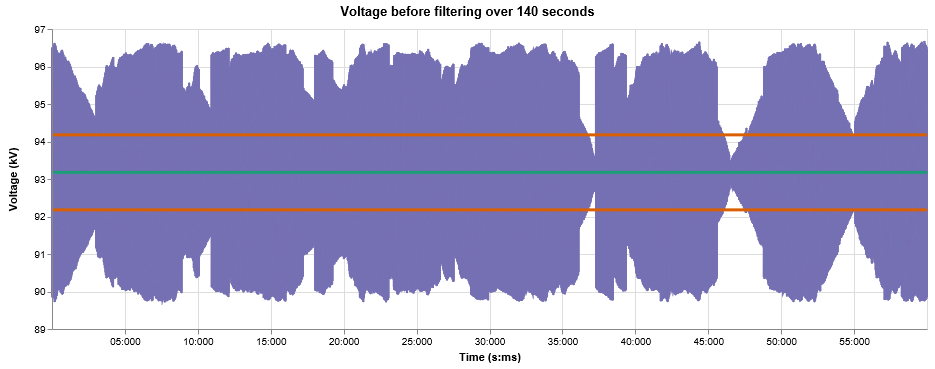

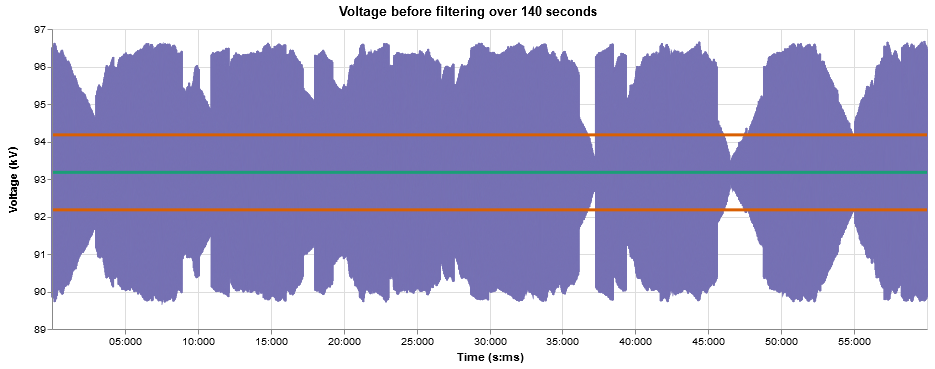

In [5]:
stability_rules_layer = generate_stability_rules(flatten_raw_data)

base_line = generate_line_chart(x_title="Time (s:ms)", y_title="Voltage (kV)", 
                                y_scale=(89,97), time_unit="secondsmilliseconds")


alt.layer(base_line, stability_rules_layer, data=flatten_raw_data, 
          title="Voltage before filtering over {} seconds".format(time_period(flatten_raw_data)),
          width=875,
          config={"background": "white"})

The line chart above shows how the voltage changes over time. The green line is the mean and the red lines are the stability bounds which are 1kV above and below the mean.

In [6]:
raw_mean = np.mean(flatten_raw_data)
raw_mean

In [7]:
raw_std = np.std(flatten_raw_data)
raw_std

In [8]:
raw_unstable_seconds = unstable_seconds(flatten_raw_data)
raw_unstable_seconds

In [9]:
percentage_of_unstable_time = (raw_unstable_seconds/140)*100
percentage_of_unstable_time

The number of unstable seconds is roughly 67% of the time, meaning that the voltage signal is currently considered permanently unstable by the IOC.

## Averaged Data

Now we will average the data by averaging values which are 180 degrees apart on the 50Hz wave. As this data was collected while sampling 100 elements at 100Hz (new reading every second) we need to average each pair of elements. We set the timestamp of the average to the later element's timestamp. Assuming the DAQ keeps sampling at 100Hz while sending the data to the IOC, this won't create artifacts at the ends of the packets of data.

In [10]:
filtered_data = dataframe_moving_average_filter(flatten_raw_data)

In [11]:
filtered_data_mean = np.mean(filtered_data)
filtered_data_mean

In [12]:
np.std(filtered_data)

In [13]:
1- np.std(filtered_data)/np.std(flatten_raw_data)

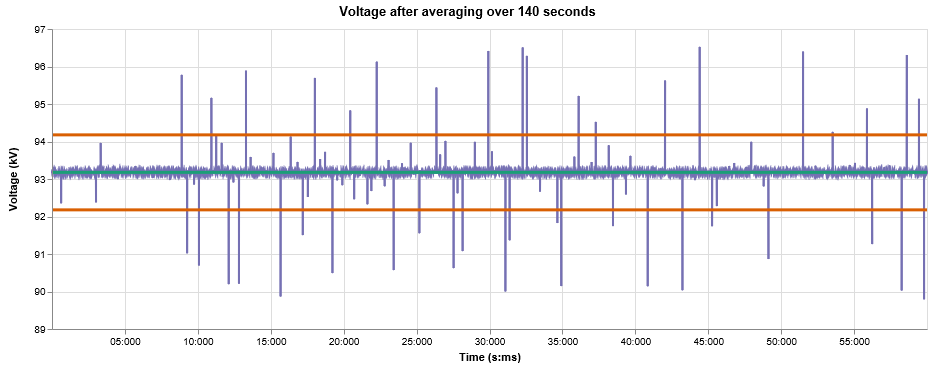

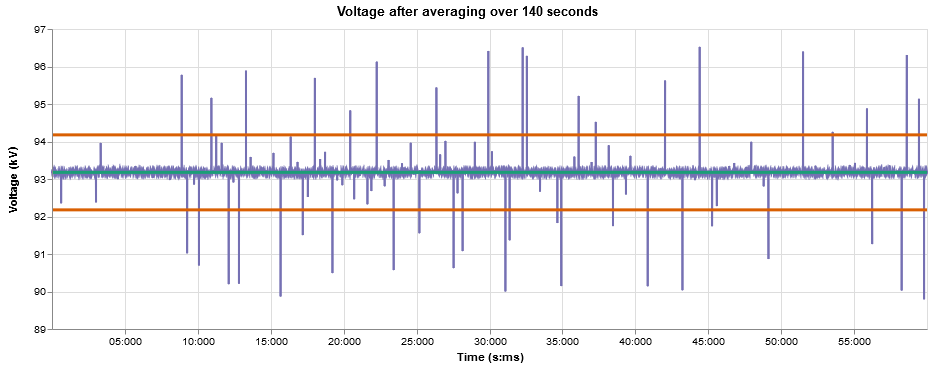

In [14]:
averaged_stability_bounds = generate_stability_rules(filtered_data)

alt.layer(base_line, averaged_stability_bounds, data=filtered_data, 
          title="Voltage after averaging over {} seconds".format(time_period(filtered_data)),
          width=875,
          config={"background": "white"})

The graph above shows how often the signal is outside of the stability parameters set at $\pm1kV$ from the mean. We also see that the signal has a standard deviation of $0.156802kV$ from a mean of $93.177131kV$. This is a $93.4785\%$ reduction of the standard deviation.

In [15]:
averaged_unstable_second = unstable_seconds(filtered_data)
averaged_unstable_second

In [16]:
1 - averaged_unstable_second/raw_unstable_seconds

The number of unstable seconds is 0.43 seconds over this 140 second window- a 99.54% decrease in the amount of time spent unstable.

## Looking at packet boundaries

In [19]:
unstable_readings = filtered_data[(filtered_data["Value"] > float(filtered_data_mean) + 1) | (filtered_data["Value"] < float(filtered_data_mean) - 1)]
unstable_readings.head(15)

,Datetime,Value
199,2018-11-09 10:46:10.930617000,95.1722
299,2018-11-09 10:46:12.120737630,90.1893
399,2018-11-09 10:46:13.303860480,95.8959
599,2018-11-09 10:46:15.674134460,89.8577
799,2018-11-09 10:46:18.028790020,95.6983
899,2018-11-09 10:46:19.231916490,90.4858
999,2018-11-09 10:46:20.452417250,94.8375
1399,2018-11-09 10:46:25.192832900,91.5442
1499,2018-11-09 10:46:26.359914490,95.4496
1599,2018-11-09 10:46:27.539733500,90.6165


In [18]:
np.std(unstable_readings["Value"])

2.5145558198821929